In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# A Decision Tree (for classification)

7.1 - The Entropy of a Partition

7.2 - The Decistion Tree Function and the Classifier 

7.3 - Example 1: The Iris Dataset

7.4 - Example 2: A Toy Dataset

7.5 - Example 3: The MNIST Dataset

## 7.1 The Entropy of a Partition

In [7]:
'entropy function'
def entropy(p):
    if p!=0:
        return -p*np.log2(p)
    else:
        return 0

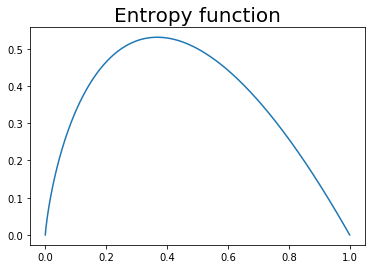

In [8]:
'plot entropy function'
x_plot = np.linspace(0,1,1000)
y_plot = np.array([entropy(x) for x in x_plot])
#plt.figure(figsize= (12,7))
plt.title('Entropy function',fontsize=20)
plt.plot(x_plot,y_plot)

In [9]:
from collections import Counter
def proportions(labels):
    total = len(labels)
    return [count/total for count in Counter(labels).values()]

In [10]:
'entropy of a subset function'
def subset_entropy(proportions):
    return np.sum([entropy(p) for p in proportions])

In [11]:
'entropy of a partition function'
def entropy_partition(subsets):
    'returns the entropy from this partion of data into subsets'
    total_count = sum(len(subset) for subset in subsets)
    return sum(subset_entropy(subset)*len(subset)/total_count for subset in subsets)

## 7.2 Decision Tree functions

In [12]:
'main function'
def decision_tree(X,labels,level=0,max_level=1):
    
    _,n_features = X.shape
    
    'let the algorithm choose the feature'
    p_list = np.zeros(n_features) 
    entropy_list = np.zeros(n_features)
    for feature in range(n_features):
    
        feature_grid = np.linspace(np.max(X[:,feature]),np.min(X[:,feature]),1000)
        entropy_grid = []
        for p in feature_grid:
            subset1 = labels[X[:,feature]>=p]
            subset2 = labels[X[:,feature]<p]
            subsets =[proportions(subset1), proportions(subset2)] #list of subset lists
            entropy_grid.append(entropy_partition(subsets))
        idx = np.argmin(entropy_grid) 
        p_list[feature] = feature_grid[idx]
        entropy_list[feature] = entropy_grid[idx]
    
    feature = np.argmin(entropy_list)
    optimal_p = p_list[feature]
    
    Tree = [optimal_p]    
    feature_Tree = [feature]
    
    #split subset X into two subsets
    X1,labels1 = X[X[:,feature]>=optimal_p], labels[X[:,feature]>=optimal_p]
    X2,labels2 = X[X[:,feature]<optimal_p], labels[X[:,feature]<optimal_p]
    
    label_Tree = []
    if len(labels1)>0: #if labels1 is not empty
        label_Tree.append(Counter(labels1).most_common()[0][0])
    else:
        label_Tree.append(9999)
    if len(labels2)>0:
        label_Tree.append(Counter(labels2).most_common()[0][0])
    else:
        label_Tree.append(9999)

    
    X_subsets = [X1,X2]
    labels_subsets = [labels1,labels2]
    
    if level<max_level:
        level = level+1
        
        Tree_next_level = []
        label_Tree_next_level = []
        feature_Tree_next_level = []
        for i in range(2):
            if len(labels_subsets[i])>0 and len(Counter(labels_subsets[i]))>1: #if nonempty and more than one class
                tree_list1,label_tree1,feature_list1 = decision_tree(X_subsets[i],labels_subsets[i],level=level,max_level=max_level)
                Tree_next_level.append(tree_list1)
                label_Tree_next_level.append(label_tree1)
                feature_Tree_next_level.append(feature_list1)
            else:
                Tree_next_level.append('stop')
                label_Tree_next_level.append('stop')
                feature_Tree_next_level.append('stop')
        
        Tree.append(Tree_next_level)
        label_Tree.append(label_Tree_next_level)
        feature_Tree.append(feature_Tree_next_level)
    return Tree,label_Tree,feature_Tree

In [13]:
def draw_partitions(Tree,feature_Tree,xlim,ylim,level=0,max_level=1):
    'only for bidimensional (two features) datasets'
    
    
    p = Tree[0]
    feature = feature_Tree[0]
    'draw the line'

    if feature==0: #vertical line
        plt.plot([p,p],ylim,'k')        
    else: #horizontal line
        plt.plot(xlim,[p,p],'k')
            

    'go one level deeper'        
    if level<max_level:
        if feature==0:
            level = level + 1
            Tree1 = Tree[1][0]
            Tree2 = Tree[1][1]
            xlim1 = [p,xlim[1]]
            xlim2 = [xlim[0],p]
            feature_Tree1 = feature_Tree[1][0]
            feature_Tree2 = feature_Tree[1][1]
            if Tree1!='stop':
                draw_partitions(Tree1,feature_Tree1,xlim1,ylim,level=level,max_level=max_level) 
            if Tree2!='stop':
                draw_partitions(Tree2,feature_Tree2,xlim2,ylim,level=level,max_level=max_level)
        else:
            level = level + 1
            Tree1 = Tree[1][0]
            Tree2 = Tree[1][1]
            ylim1 = [p,ylim[1]]
            ylim2 = [ylim[0],p]
            feature_Tree1 = feature_Tree[1][0]
            feature_Tree2 = feature_Tree[1][1]
            if Tree1 != 'stop':
                draw_partitions(Tree1,feature_Tree1,xlim,ylim1,level=level,max_level=max_level)
            if Tree2 != 'stop':
                draw_partitions(Tree2,feature_Tree2,xlim,ylim2,level=level,max_level=max_level)  

In [14]:
'classifier function'
def tree_classifier(tree,label_tree,feature_tree,new_point,max_level):
    next_level = True
    level = 0
    while level<max_level:
        feature = feature_tree[0]
        p = tree[0]
        if new_point[feature]>=p:
            new_label = label_tree[0]
            tree = tree[1][0]
            label_tree = label_tree[2][0]
            feature_tree = feature_tree[1][0]
            if label_tree == 'stop':
                return new_label
        else:
            new_label = label_tree[1]
            tree = tree[1][1]
            label_tree = label_tree[2][1]
            feature_tree = feature_tree[1][1]
            if label_tree == 'stop':
                return new_label
        level = level + 1
        
    'deepest level'
    p = tree[0]
    feature = feature_tree[0]
    if new_point[feature]>=p:
        new_label = label_tree[0]
    else:
        new_label = label_tree[1]
    return new_label

## 7.3 Example 1: The Iris Dataset

In [14]:
'load iris dataset'
url = 'https://raw.githubusercontent.com/um-perez-alvaro/lin-regress/master/iris.data'
iris_data = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','species'])
iris_data.head(5) #first 5 rows

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [15]:
X = iris_data.iloc[:,2:4].to_numpy() # petal length and width
labels = np.array(iris_data['species'])  #labels as a row vector
X.shape

(150, 2)

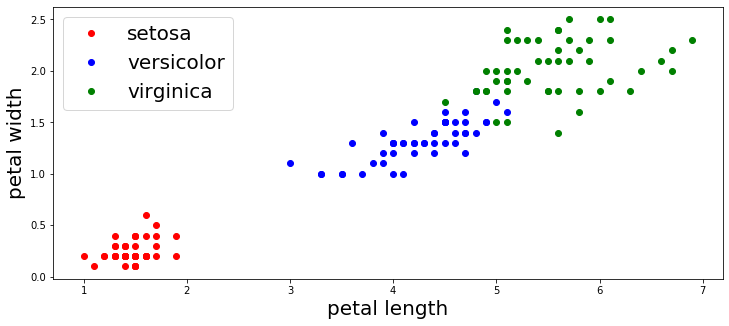

In [16]:
'plot the dataset'
colors = ['red','blue']
plt.figure(figsize=(12,5))
plt.plot(X[labels == 'Iris-setosa',0],X[labels=='Iris-setosa',1],'ro',label='setosa')
plt.plot(X[labels == 'Iris-versicolor',0],X[labels== 'Iris-versicolor',1],'bo',label ='versicolor')
plt.plot(X[labels == 'Iris-virginica',0],X[labels == 'Iris-virginica',1],'go',label ='virginica')
plt.xlabel('petal length',fontsize=20)
plt.ylabel('petal width', fontsize=20)
plt.legend(fontsize=20)

In [19]:
max_level = 2
Tree,label_Tree,feature_Tree = decision_tree(X,labels,max_level=max_level)

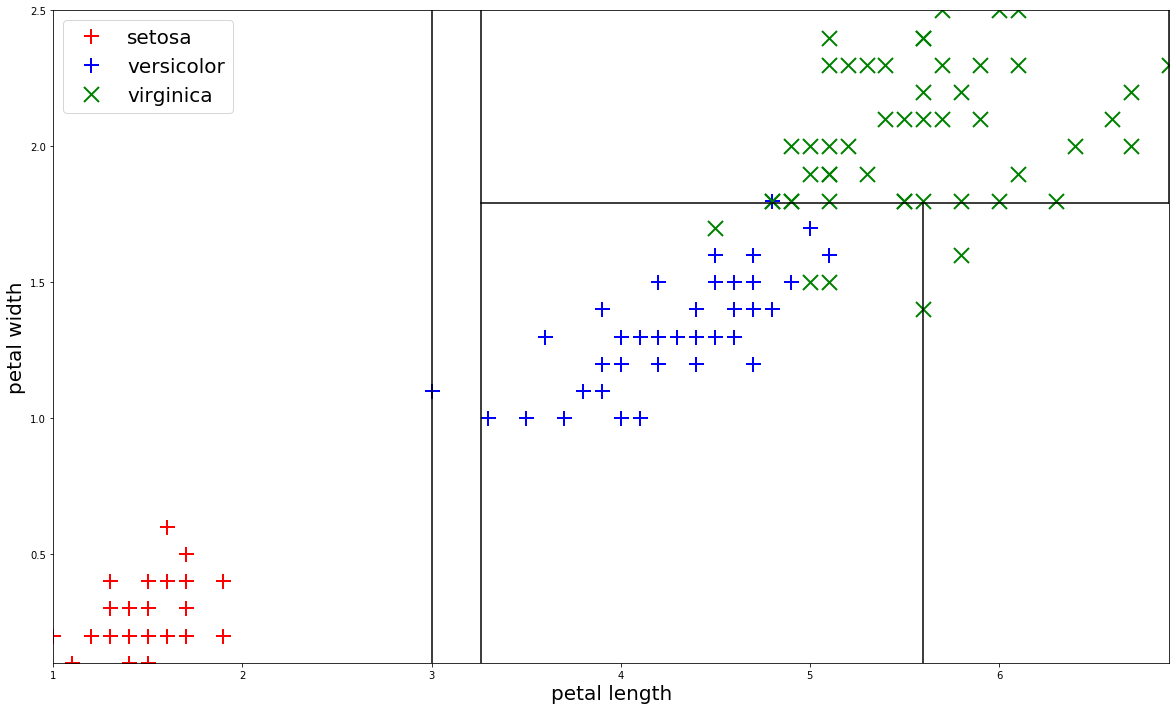

In [22]:
'plot dataset'
plt.figure(figsize=(20,12))
plt.plot(X[labels == 'Iris-setosa',0],X[labels=='Iris-setosa',1],'r+',label='setosa',markersize=15,mew=2)
plt.plot(X[labels == 'Iris-versicolor',0],X[labels== 'Iris-versicolor',1],'b+',label ='versicolor',mew=2,ms=15)
plt.plot(X[labels == 'Iris-virginica',0],X[labels == 'Iris-virginica',1],'gx',label ='virginica',mew=2,ms=15)
plt.xlabel('petal length',fontsize=20)
plt.ylabel('petal width', fontsize=20)
plt.legend(fontsize=20)
plt.xlim(np.min(X[:,0]),np.max(X[:,0]))
plt.ylim(np.min(X[:,1]),np.max(X[:,1]))

'plot partitions'
xlim = [np.min(X[:,0]),np.max(X[:,0])]
ylim = [np.min(X[:,1]),np.max(X[:,1])] 
max_level = 2
draw_partitions(Tree,feature_Tree,xlim,ylim,max_level=max_level)

In [25]:
new_point = [6,2.2]
tree_classifier(Tree,label_Tree,feature_Tree,new_point,max_level=2)

'Iris-virginica'

## 7.4 Example 2: A Toy Dataset

Text(0.5, 1.0, 'A Toy Dataset')

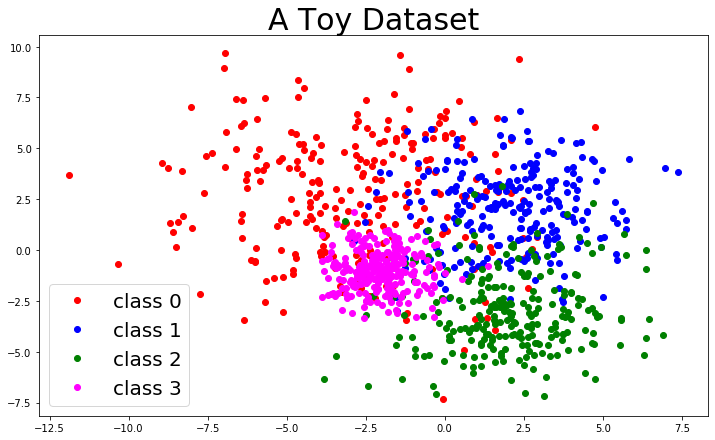

In [68]:
X = np.zeros((1000,2)) #2 features; 1000 data points; 4 classes
labels = np.zeros(1000)

X[0:250] = 3*np.random.randn(250,2) + [-3,3]
labels[0:200] = 0

X[250:500] = 2*np.random.randn(250,2) + [2,2]
labels[250:500] = 1 

X[500:750] = 2*np.random.randn(250,2) + [2,-3]
labels[500:750] = 2

X[750:1000] = np.random.randn(250,2) + [-2,-1]
labels[750:1000] = 3

colors = ['red','blue','green','magenta']
plt.figure(figsize=(12,7))
for i in range(4):
    plt.plot(X[labels==i,0],X[labels==i,1],'o',color=colors[i],label = 'class '+str(i))
    plt.legend(fontsize=20)
plt.title('A Toy Dataset',fontsize=30)

In [69]:
'randomly permute the dataset'
idx = np.random.permutation(np.arange(len(labels)))
X = X[idx]
labels = labels[idx]

In [70]:
'split dataset into training, validation and test sets'
X_train,labels_train = X[:600],labels[:600] # to train the model
X_val,labels_val = X[600:800],labels[600:800] # to choose max_level
X_test,labels_test = X[800:],labels[800:] # to test the model

In [ ]:
'train the Decision Tree'
max_level = 100
Tree,label_Tree,feature_Tree = decision_tree(X_train,labels_train,max_level=max_level)

(-7.3000277047311215, 9.708203674958492)

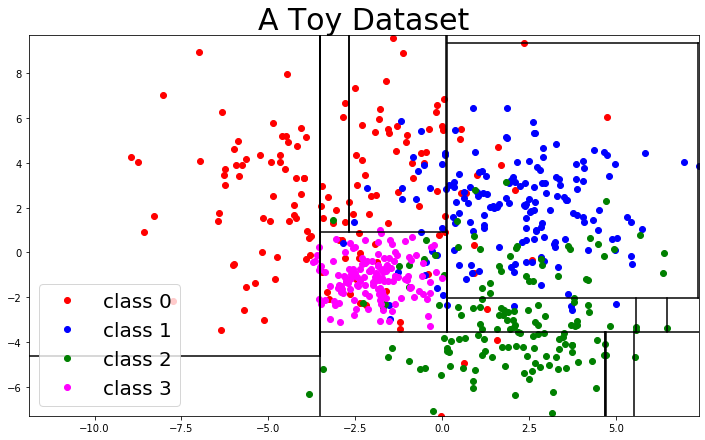

In [72]:
'plot partitions'
colors = ['red','blue','green','magenta']
plt.figure(figsize=(12,7))
for i in range(4):
    plt.plot(X_train[labels_train==i,0],X_train[labels_train==i,1],'o',color=colors[i],label = 'class '+str(i))
    plt.legend(fontsize=20)
plt.title('A Toy Dataset',fontsize=30)


xlim = [np.min(X[:,0]),np.max(X[:,0])]
ylim = [np.min(X[:,1]),np.max(X[:,1])] 
draw_partitions(Tree,feature_Tree,xlim,ylim,max_level=5)
plt.xlim(xlim)
plt.ylim(ylim)

In [73]:
'Find the optimal max_level'
max_level_list = [level for level in range(40)] # [0,1,2,...]

'train the model'
Tree,label_Tree,feature_Tree = decision_tree(X_train,labels_train,max_level=40)
p_incorrect = np.zeros(40)
for max_level in max_level_list:
    'Test the model on the validation set'
    labels_val_predicted = np.array([tree_classifier(Tree,label_Tree,feature_Tree,X_val[i],max_level=max_level)
                                  for i in range(len(labels_val))])
    'Percentage of incorrect classifications'
    p_incorrect[max_level] = 100*sum(labels_val_predicted!=labels_val)/len(labels_val)
    

Text(0.5, 1.0, 'percentage of incorrect classifications')

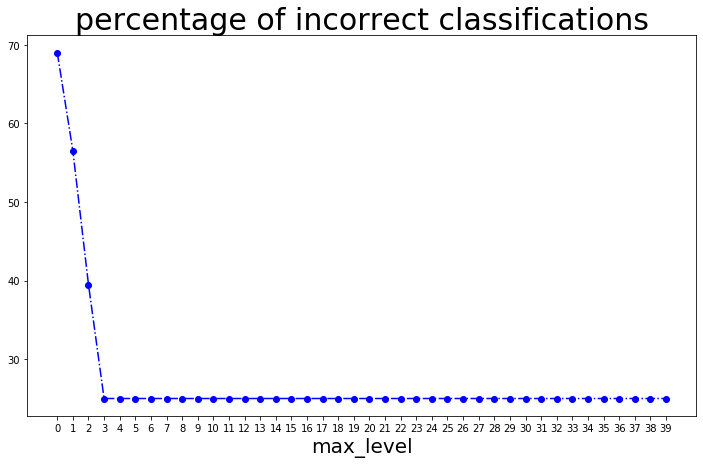

In [74]:
plt.figure(figsize=(12,7))
plt.plot(max_level_list,p_incorrect,'b-.o')
plt.xticks(max_level_list)
plt.xlabel('max_level',fontsize=20)
plt.title('percentage of incorrect classifications',fontsize=30)

In [75]:
'Train the Decision Tree'
max_level = 3 # optimal max_level
Tree,label_Tree,feature_Tree = decision_tree(X_train,labels_train,max_level=max_level)
'Test the model on the test set'
labels_test_predicted = np.array([tree_classifier(Tree,label_Tree,feature_Tree,X_test[i],max_level=max_level)
                                  for i in range(len(labels_test))])
    

In [76]:
'Confusion matrix'
C = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        C[i,j] = sum(labels_test_predicted[labels_test==i]==j)
C

array([[40., 10.,  1.,  3.],
       [ 3., 36.,  0.,  2.],
       [ 1., 10., 34.,  1.],
       [ 6.,  0.,  0., 53.]])

In [77]:
'Percentage of correct classifications'
100*sum(labels_val_predicted==labels_val)/len(labels_val)

75.0

## Another Toy Example

Text(0.5, 1.0, 'A Toy Dataset')

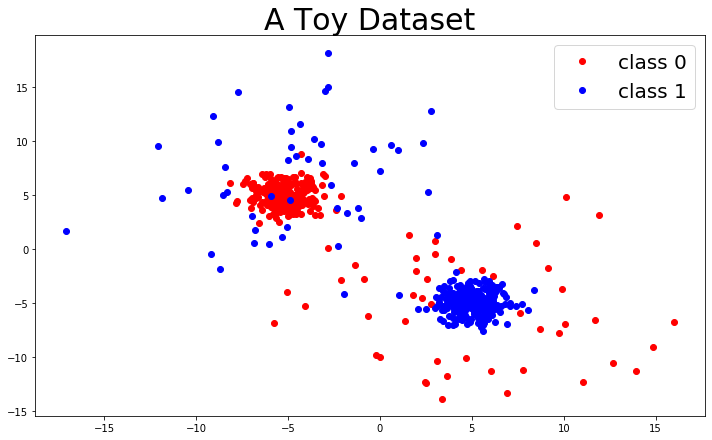

In [15]:
X = np.zeros((600,2)) #2 features; 1000 data points; 4 classes
labels = np.zeros(600)

X[0:250] = np.random.randn(250,2) + [-5,5]
labels[0:200] = 0

X[250:500] = np.random.randn(250,2) + [5,-5]
labels[250:500] = 1 

X[500:550] = 5*np.random.randn(50,2) + [-5,5]
labels[500:550] = 1

X[550:600] = 5*np.random.randn(50,2) + [5,-5]
labels[550:600] = 0

colors = ['red','blue','green','magenta']
plt.figure(figsize=(12,7))
for i in range(2):
    plt.plot(X[labels==i,0],X[labels==i,1],'o',color=colors[i],label = 'class '+str(i))
    plt.legend(fontsize=20)
plt.title('A Toy Dataset',fontsize=30)

In [16]:
'randomly permute the dataset'
idx = np.random.permutation(np.arange(len(labels)))
X = X[idx]
labels = labels[idx]

In [17]:
'train the Decision Tree'
max_level = 100
Tree,label_Tree,feature_Tree = decision_tree(X,labels,max_level=max_level)

(-13.80990659347335, 18.23345845875545)

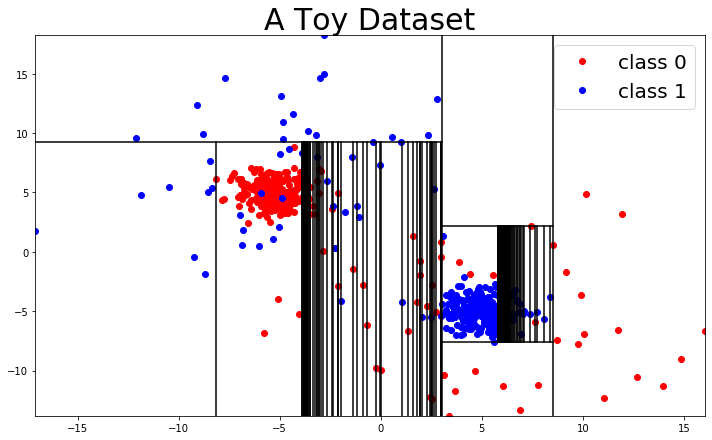

In [18]:
'plot partitions'
colors = ['red','blue','green','magenta']
plt.figure(figsize=(12,7))
for i in range(2):
    plt.plot(X[labels==i,0],X[labels==i,1],'o',color=colors[i],label = 'class '+str(i))
    plt.legend(fontsize=20)
plt.title('A Toy Dataset',fontsize=30)


xlim = [np.min(X[:,0]),np.max(X[:,0])]
ylim = [np.min(X[:,1]),np.max(X[:,1])] 
draw_partitions(Tree,feature_Tree,xlim,ylim,max_level=60)
plt.xlim(xlim)
plt.ylim(ylim)

## 7.5 Example 3: the MNIST dataset

In [18]:
'Obtain the MNist dataset'
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
X,y=mnist['data'],mnist['target']
labels = y.astype(np.uint8) #8-bit unsigned integer array

In [19]:
X,labels = X[:500],labels[:500] #we'll use only 2000 digits

In [25]:
'split dataset into training, validation and test sets'
X_train,labels_train = X[:300],labels[:300] # to train the model
X_val,labels_val = X[300:400],labels[300:400] # to choose max_level
X_test,labels_test = X[400:],labels[400:] # to test the model

In [28]:
'Find the optimal max_level'
max_level_list = [level for level in range(20)] # [0,1,2,...]

p_incorrect = np.zeros(20)
for max_level in max_level_list:
    print(max_level)
    'train the model'
    Tree,label_Tree,feature_Tree = decision_tree(X_train,labels_train,max_level=max_level)
    'Test the model on the validation set'
    labels_val_predicted = np.array([tree_classifier(Tree,label_Tree,feature_Tree,X_val[i],max_level=max_level)
                                  for i in range(len(labels_val))])
    'Percentage of incorrect classifications'
    p_incorrect[max_level] = 100*sum(labels_val_predicted!=labels_val)/len(labels_val)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'percentage of incorrect classifications')

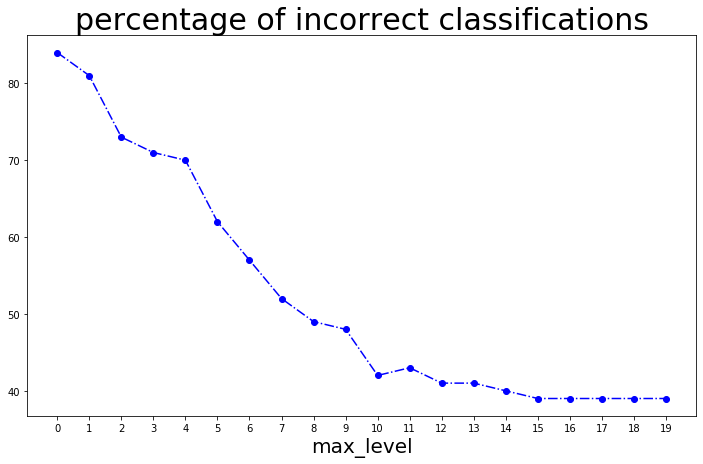

In [29]:
plt.figure(figsize=(12,7))
plt.plot(max_level_list,p_incorrect,'b-.o')
plt.xticks(max_level_list)
plt.xlabel('max_level',fontsize=20)
plt.title('percentage of incorrect classifications',fontsize=30)

# Random Forest (under construction)

In [223]:
'split training set into 6 subsets'
X_list = [X_train[i*100:(i+1)*100] for i in range(6)]
labels_list = [labels_train[i*100:(i+1)*100] for i in range(6)]

In [224]:
'train 6 decision trees'
Forest = [decision_tree(X_list[i],labels_list[i],max_level=5) for i in range(6)]

In [225]:
new_point = [2.5,0]
new_labels = [tree_classifier(Forest[i][0],Forest[i][1],Forest[i][2],new_point,max_level=5) for i in range(6)]

In [226]:
Counter(new_labels).most_common()[0][0]

1.0

In [227]:
labels_test_predicted = []
for j in range(len(labels_test)):
    new_point = X_test[j]
    new_labels = [tree_classifier(Forest[i][0],Forest[i][1],Forest[i][2],new_point,max_level=5) for i in range(6)]
    labels_test_predicted.append(Counter(new_labels).most_common()[0][0])
labels_test_predicted = np.array(labels_test_predicted).astype('int')

In [228]:
C = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        C[i,j] = sum(labels_test_predicted[labels_test==i]==j)
C

array([[33.,  8.,  0.,  7.],
       [ 6., 40.,  5.,  2.],
       [ 0.,  3., 42., 10.],
       [ 2.,  0.,  1., 40.]])